# Notes for geoinformatics
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import geodatasets

# Hemispheres
---

**North**
- **High**: Anticylonic divergent (*clockwise*)
- **Low** : Cylonic convergent (*counterclockwise*)

**South**
- **High**: Anticyclonic divergent (*counterclockwise*)
- **Low** : Cyclonic convergent (*clockwise*)

In [2]:
R = 6_371_000 # Eearths radius in meters

In [3]:
world_path = geodatasets.get_path("naturalearth.land")

In [4]:
world = gpd.read_file(world_path)

In [5]:
spirals_path = geodatasets.get_path("geoda.spirals")

In [6]:
spirals_df = pd.read_csv(spirals_path).astype({"x": float, "y": float})

In [7]:
geodatasets.data.flatten().keys()

dict_keys(['geoda.airbnb', 'geoda.atlanta', 'geoda.cars', 'geoda.charleston1', 'geoda.charleston2', 'geoda.chicago_health', 'geoda.chicago_commpop', 'geoda.chile_labor', 'geoda.cincinnati', 'geoda.cleveland', 'geoda.grid100', 'geoda.groceries', 'geoda.guerry', 'geoda.health', 'geoda.health_indicators', 'geoda.hickory1', 'geoda.hickory2', 'geoda.home_sales', 'geoda.houston', 'geoda.juvenile', 'geoda.lansing1', 'geoda.lansing2', 'geoda.lasrosas', 'geoda.liquor_stores', 'geoda.malaria', 'geoda.milwaukee1', 'geoda.milwaukee2', 'geoda.ncovr', 'geoda.natregimes', 'geoda.ndvi', 'geoda.nepal', 'geoda.nyc', 'geoda.nyc_earnings', 'geoda.nyc_education', 'geoda.nyc_neighborhoods', 'geoda.orlando1', 'geoda.orlando2', 'geoda.oz9799', 'geoda.phoenix_acs', 'geoda.police', 'geoda.sacramento1', 'geoda.sacramento2', 'geoda.savannah1', 'geoda.savannah2', 'geoda.seattle1', 'geoda.seattle2', 'geoda.sids', 'geoda.sids2', 'geoda.south', 'geoda.spirals', 'geoda.stlouis', 'geoda.tampa1', 'geoda.us_sdoh', 'ny.bb

In [8]:
# City, lon, lat
bogota = (-74.0722, 4.7111)
comodoro_rivadavia = (-67.4808, -45.8647)
delhi = (77.2300, 28.6100)
east_london = (27.9047, -33.0175)
jakarta = (106.8275, -6.175)
lagos = (3.3841, 6.4550)
melbourne = (144.9631, -37.8142)
paris = (2.3522, 48.8567)
san_francisco = (-122.4449, 37.7558 )
tokyo = (139.6922, 35.6897)
toronto = (-79.3733, 43.7417)

cities = [bogota, comodoro_rivadavia, delhi, east_london, jakarta, lagos, melbourne, paris, tokyo, san_francisco, toronto]

In [9]:
def cartesian_to_geo(x, y, lon0, lat0):
    # Reference point
    lon0_rad = np.radians(lon0)
    lat0_rad = np.radians(lat0)

    # New lat and lon
    lon = lon0 + np.degrees(x / (R * np.cos(lat0_rad)))
    lat = lat0 + np.degrees(y / R)

    return lon, lat


In [10]:
def geo_to_cartesian(lon, lat, lon0, lat0):
    # Reference point
    lon0_rad = np.radians(lon0)
    lat0_rad = np.radians(lat0)

    # x (East), y (North), z (Up)
    x = (np.radians(lon - lon0) * R * np.cos(lat0_rad))
    y = (np.radians(lat - lat0) * R)

    return x, y

In [11]:
def get_spiral_gdf(df, x, y, lon, lat, scale):
    df["lng"] = df.apply(lambda row: cartesian_to_geo(row[x] * scale[0], row[y] * scale[1], lon, lat)[0], axis=1)
    df["lat"] = df.apply(lambda row: cartesian_to_geo(row[x] * scale[0], row[y] * scale[1], lon, lat)[1], axis=1)

    spiral_points = [Point(x, y) for x, y in zip(spirals_df["lng"], spirals_df["lat"])]
    spiral_gdf = gpd.GeoDataFrame(geometry=spiral_points, crs="EPSG:4326")

    return spiral_gdf

In [12]:
def get_pressure_gdf(df, mode : str, lon=0, lat=0, scale=[1,1]):
    if mode not in ["h", "l"]:
        raise NameError("Mode unsupportet")

    scale = scale.copy()
    signs = [1, 1]
    color = "green"

    # South
    if lat <= 0:
        # Low
        if mode == "l":
            color = "blue"
        # High
        elif mode == "h":
            color = "red"
            signs[1] = -1
    # North
    elif lat > 0:
        if mode == "l":
            color = "blue"
            signs[1] = -1
        elif mode == "h":
            color = "red"

    scale[0] *= signs[0]
    scale[1] *= signs[1]
    
    gdf = get_spiral_gdf(df, "x", "y", lon, lat, scale)

    return (gdf, color)

In [13]:
scale = [1_000_000, 1_000_000] # 1_000 km = 1_000_000 m

In [14]:
low = [get_pressure_gdf(spirals_df, "l", city[0], city[1], scale) for i, city in enumerate(cities) if i % 2 == 0]
high = [get_pressure_gdf(spirals_df, "h", city[0], city[1], scale) for i, city in enumerate(cities) if i % 2 == 1]
pressure_systems = low + high

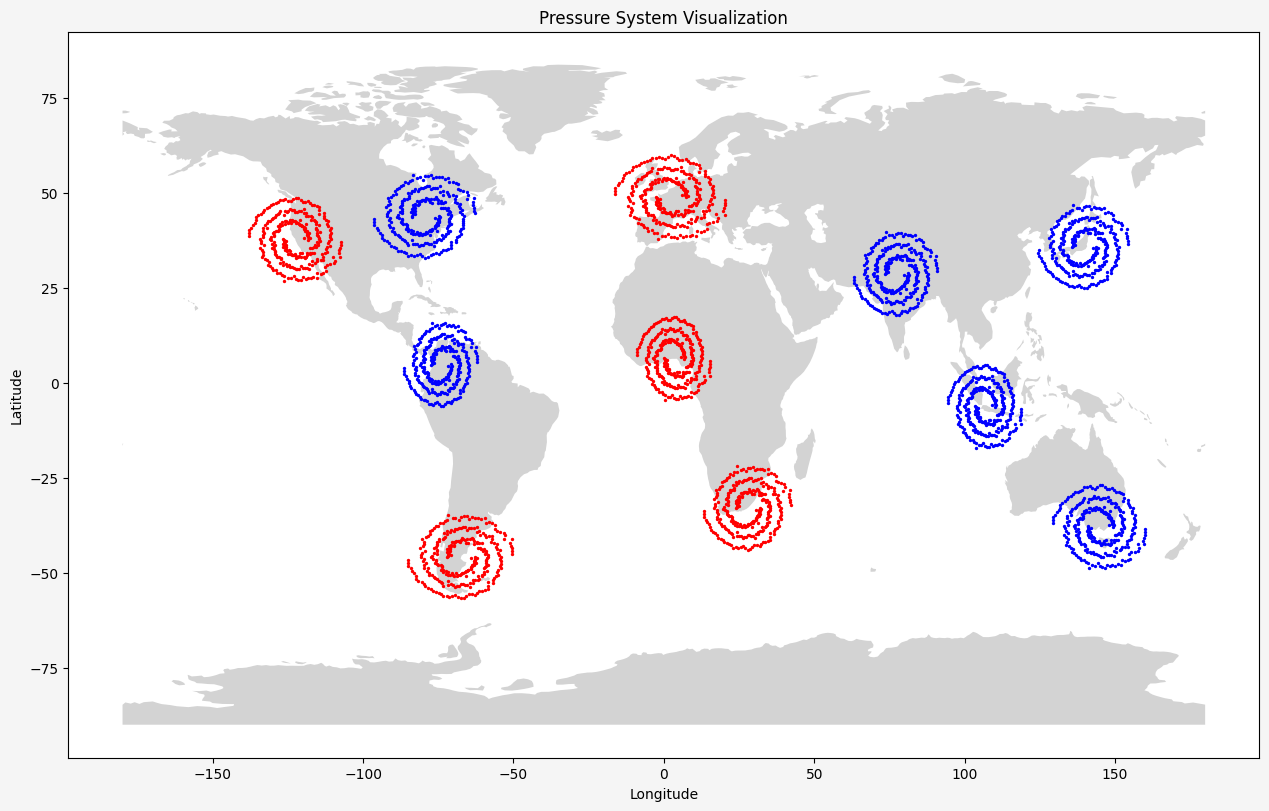

In [15]:
fig, ax = plt.subplots(figsize=(16, 8), facecolor="whitesmoke", layout="constrained")
world.plot(ax=ax, color="lightgrey")

for pressure_system in pressure_systems: 
    pressure_system[0].plot(ax=ax, marker="o", markersize=2, color=pressure_system[1])
    

ax.set_title("Pressure System Visualization")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [16]:
# Section yet to be written...